### Pokemon DataSet Preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from keras.preprocessing import image

In [2]:
p = Path("./Dataset")
dirs = p.glob("*")

image_data = []
labels = []

label_dict = {}

i = 0

for img_folder in dirs:

    label = str(img_folder).split("\\")[-1]
    label_dict[label] = i
    i += 1
    
    print(img_folder)
    cnt = 0
    
    # Iterate over all img_folders and extract all images
    for img_path in img_folder.glob("*.jpg"):
        img = image.load_img(img_path , target_size = (40, 40))
        img_array = image.img_to_array(img)
        image_data.append(img_array)
        
        labels.append(label_dict[label])
        cnt += 1
    
    print(cnt)

Dataset\Bulbasaur
173
Dataset\Meowth
70
Dataset\Pikachu
199


In [3]:
label2pokemon = {v:k for k, v in label_dict.items()}

In [4]:
print(label2pokemon)

{0: 'Bulbasaur', 1: 'Meowth', 2: 'Pikachu'}


In [5]:
print(len(image_data))
print(len(labels))

442
442


In [6]:
x = np.array(image_data , dtype = np.uint8)
y = np.array(labels)

from sklearn.utils import shuffle
x, y = shuffle(x, y, random_state = 2)

print(x.shape , y.shape)

(442, 40, 40, 3) (442,)


### Visualization

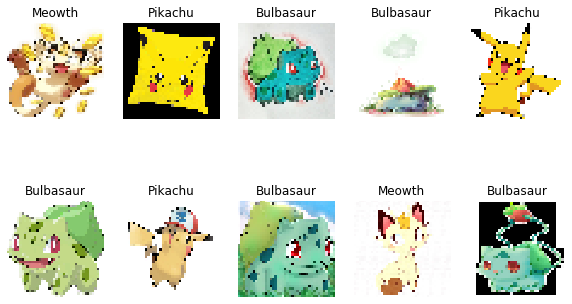

In [7]:
plt.figure(figsize = (10, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x[i])
    plt.title(label2pokemon[y[i]])
    plt.axis('off')

### Split data into train and test dataset

In [8]:
split = int(x.shape[0]*0.8)

x_train = x[:split, :]
x_test = x[split:, :]

y_train = y[:split]
y_test = y[split:]

print(x_train.shape , x_test.shape , y_train.shape , y_test.shape)

(353, 40, 40, 3) (89, 40, 40, 3) (353,) (89,)


In [9]:
x_train = x_train.reshape((x_train.shape[0], -1))
print(x_train.shape)

x_test = x_test.reshape((x_test.shape[0], -1))
print(x_test.shape)

(353, 4800)
(89, 4800)


### Image Classification using Neural Network

In [10]:
def softmax(a):
    e_pa = np.exp(a)   # Vector
    ans = e_pa/np.sum(e_pa, axis = 1, keepdims = True)
    return ans

def relu(z):
    return np.maximum(0, z)

def reluDerivative(x):
    return np.heaviside(x, 1)

In [11]:
def one_hot_encoding(y, depth):
    m = y.shape[0]
    y_oht = np.zeros((m, depth))
    y_oht[np.arange(m) , y] = 1
    return y_oht

In [49]:
class NeuralNetwork:
    
    def __init__(self , input_size , layers , output_size):
        np.random.seed(3)
        
        model = {} 
        
        # First Layer
        model['w1'] = np.random.randn(input_size,layers[0])
        model['b1'] = np.zeros((1, layers[0]))
        
        # Second Layer
        model['w2'] = np.random.randn(layers[0],layers[1])
        model['b2'] = np.zeros((1, layers[1]))
        
        # Third/Output Layer
        model['w3'] = np.random.randn(layers[1],output_size)
        model['b3'] = np.zeros((1, output_size))
        
        self.model = model
    
    def forward(self, x):
        
        w1, w2, w3 = self.model['w1'], self.model['w2'], self.model['w3']
        b1, b2, b3 = self.model['b1'], self.model['b2'], self.model['b3']
        
        z1 = np.dot(x, w1) + b1
        a1 = np.tanh(z1) 
        
        z2 = np.dot(a1, w2) + b2
        a2 = np.tanh(z2)
        
        z3 = np.dot(a2, w3) + b3
        y_ = softmax(z3)
        
        self.activation_outputs = (a1,a2,y_)
        return y_
        
    def backward(self, x, y, learning_rate=0.001):
        
        w1, w2, w3 = self.model['w1'], self.model['w2'], self.model['w3']
        b1, b2, b3 = self.model['b1'], self.model['b2'], self.model['b3']
        a1, a2, y_ = self.activation_outputs
        m = x.shape[0]
        
        delta3 = y_ - y
        dw3 = np.dot(a2.T , delta3)
        db3 = np.sum(delta3 , axis = 0)/float(m)
        
        delta2 = (1-np.square(a2))*np.dot(delta3 , w3.T)
        dw2 = np.dot(a1.T , delta2)
        db2 = np.sum(delta2 , axis = 0)/float(m)
        
        delta1 = (1-np.square(a1))*np.dot(delta2 , w2.T)
        dw1 = np.dot(x.T , delta1)
        db1 = np.sum(delta1 , axis = 0)/float(m)
        
        
        # Update the Model Parameters using Gradient Descent
        self.model["w1"]  -= learning_rate*dw1
        self.model['b1']  -= learning_rate*db1
        
        self.model["w2"]  -= learning_rate*dw2
        self.model['b2']  -= learning_rate*db2
        
        self.model["w3"]  -= learning_rate*dw3
        self.model['b3']  -= learning_rate*db3
        
    def predict(self , x):
        y_out = self.forward(x)
        return np.argmax(y_out , axis=1)
    
    def summary(self):
        
        w1, w2, w3 = self.model['w1'], self.model['w2'], self.model['w3']
        b1, b2, b3 = self.model['b1'], self.model['b2'], self.model['b3']
        a1, a2, y_ = self.activation_outputs
        
        print("W1 " , w1.shape)
        print("B1 " , b1.shape)
        print("A1 " , a1.shape)
        
        print("W2 " , w2.shape)
        print("B2 " , b2.shape)
        print("A2 " , a2.shape)
        
        print("W3 " , w3.shape)
        print("B3 " , b3.shape)
        print("Y_ " , y_.shape) 

In [66]:
def loss(y_oht, p):
    l = -np.mean(y_oht*np.log(p))   # categorical cross entropy loss function
    return l

def train(x , y , model , max_epochs = 200 , learning_rate = 0.001 , logs=True):
    losses = []
    
    classes = len(np.unique(y))
    y_oht = one_hot_encoding(y , classes)
    
    for epoch in range(1, max_epochs+1):
        
        y_ = model.forward(x)
        l = loss(y_oht , y_)
        model.backward(x , y_oht , learning_rate)
        losses.append(l)
        
        if(logs and epoch%50==0):
            print("Epoch %d Loss %.4f"%(epoch,l))
            
    return losses

In [72]:
model = NeuralNetwork(input_size = 4800 , layers = [256, 64] , output_size = 3)

In [73]:
model.forward(x_train).shape
model.summary()

W1  (4800, 256)
B1  (1, 256)
A1  (353, 256)
W2  (256, 64)
B2  (1, 64)
A2  (353, 64)
W3  (64, 3)
B3  (1, 3)
Y_  (353, 3)


### Training the Model

In [74]:
l = train(x_train , y_train , model , 400 , 0.0002)

Epoch 50 Loss 0.5092
Epoch 100 Loss 0.2988
Epoch 150 Loss 0.2128
Epoch 200 Loss 0.1580
Epoch 250 Loss 0.1270
Epoch 300 Loss 0.1073
Epoch 350 Loss 0.0935
Epoch 400 Loss 0.0832


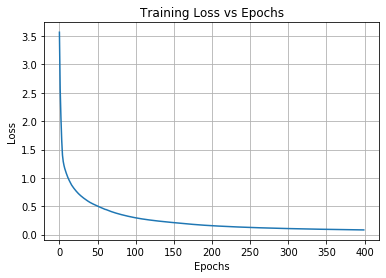

In [75]:
plt.plot(l)
plt.title("Training Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [76]:
def getAccuracy(x, y, model):
    output = model.predict(x)
    return (np.sum(output == y)/y.shape[0])*100

print("Train Accuracy %.4f" %getAccuracy(x_train ,y_train , model))
print("Test Accuracy %.4f" %getAccuracy(x_test , y_test , model))

Train Accuracy 93.4844
Test Accuracy 60.6742


### Pokemon Classification Report and Confusion Matrix

In [77]:
from sklearn.metrics import confusion_matrix
from Visualize import plot_confusion_matrix

In [78]:
outputs = model.predict(x_train)

In [79]:
cnf_matrix = confusion_matrix(outputs , y_train)
print(cnf_matrix)

[[124   3   3]
 [  2  52   4]
 [  6   5 154]]


Confusion matrix, without normalization
[[124   3   3]
 [  2  52   4]
 [  6   5 154]]


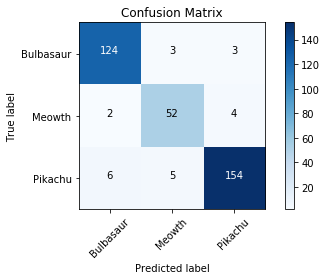

In [80]:
plot_confusion_matrix(cnf_matrix , classes = ["Bulbasaur", "Meowth", "Pikachu"] , title = "Confusion Matrix")

In [81]:
from sklearn.metrics import classification_report

In [82]:
print(classification_report(outputs, y_train))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       130
           1       0.87      0.90      0.88        58
           2       0.96      0.93      0.94       165

   micro avg       0.93      0.93      0.93       353
   macro avg       0.92      0.93      0.92       353
weighted avg       0.94      0.93      0.94       353



In [83]:
test_outputs = model.predict(x_test)
print(classification_report(test_outputs, y_test))

              precision    recall  f1-score   support

           0       0.66      0.73      0.69        37
           1       0.20      0.12      0.15        16
           2       0.66      0.69      0.68        36

   micro avg       0.61      0.61      0.61        89
   macro avg       0.51      0.52      0.51        89
weighted avg       0.58      0.61      0.59        89



In [84]:
cnf_matrix = confusion_matrix(test_outputs , y_test)
print(cnf_matrix)

[[27  5  5]
 [ 6  2  8]
 [ 8  3 25]]


Confusion matrix, without normalization
[[27  5  5]
 [ 6  2  8]
 [ 8  3 25]]


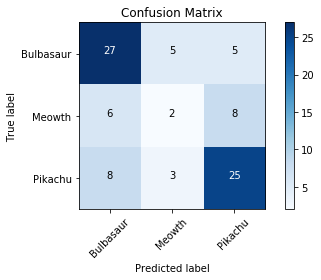

In [85]:
plot_confusion_matrix(cnf_matrix , classes = ["Bulbasaur", "Meowth", "Pikachu"] , title = "Confusion Matrix")

### Visualize Misclassifications

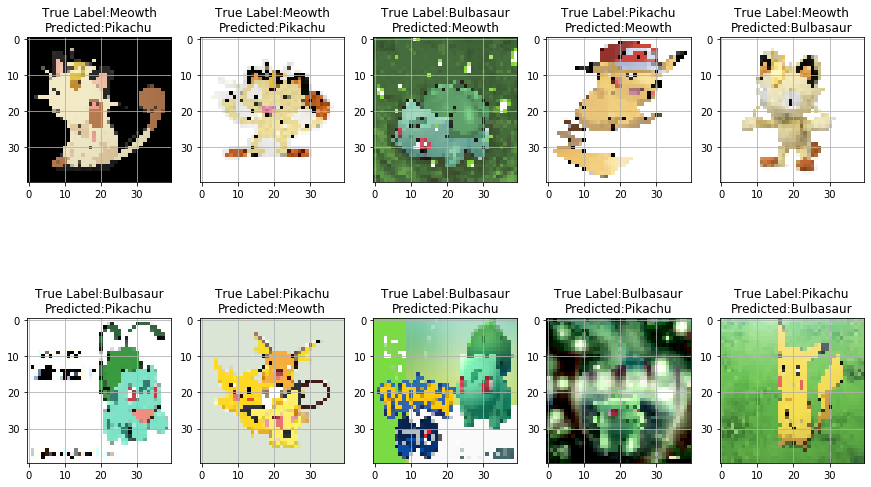

In [92]:
plt.figure(figsize=(15, 25))
cnt = 0
for i in range(y_train[:180].shape[0]):
    
    if outputs[i] != y_train[i]:
        
        plt.subplot(5, 5, cnt+1)
        plt.imshow(x_train[i].reshape(40, 40, 3))
        plt.title("True Label:"+label2pokemon[y_train[i]]+'\n'+"Predicted:"+label2pokemon[outputs[i]])
        cnt += 1
        
        plt.grid('off')